#Machine Learning Final Project
##Predicting Students' Test Scores in Math and Portugese
####Group 6: 


> Allison Anson, Nat Arney, David Hackenbracht, and Matthew Sawberger

######Source of data set: http://archive.ics.uci.edu/ml/datasets/Student+Performance
---





In [ ]:
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, f1_score, classification_report, precision_score, auc, plot_confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import time
import itertools

%matplotlib inline

In [ ]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip

--2021-04-27 17:34:28--  http://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20478 (20K) [application/x-httpd-php]
Saving to: ‘student.zip’

student.zip         100%[===================>]  20.00K  --.-KB/s    in 0.04s   

2021-04-27 17:34:28 (561 KB/s) - ‘student.zip’ saved [20478/20478]



In [ ]:
# extract contents from data zip file and remove zip file, show files
with zipfile.ZipFile("student.zip", 'r') as zip_ref:
    zip_ref.extractall()

%rm -rf *.zip
%ls

sample_data/  student-mat.csv  student-merge.R  student-por.csv  student.txt


In [ ]:
# read data from math and portugese data sets into their own dataframe
df_por = pd.read_csv('student-por.csv', sep=';', header=0)
df_mat = pd.read_csv('student-mat.csv', sep=';', header=0)

In [ ]:
print(df_por.head())
print(df_mat.head())

  school sex  age address famsize Pstatus  ...  Walc  health absences  G1  G2  G3
0     GP   F   18       U     GT3       A  ...     1       3        4   0  11  11
1     GP   F   17       U     GT3       T  ...     1       3        2   9  11  11
2     GP   F   15       U     LE3       T  ...     3       3        6  12  13  12
3     GP   F   15       U     GT3       T  ...     1       5        0  14  14  14
4     GP   F   16       U     GT3       T  ...     2       5        0  11  13  13

[5 rows x 33 columns]
  school sex  age address famsize Pstatus  ...  Walc  health absences  G1  G2  G3
0     GP   F   18       U     GT3       A  ...     1       3        6   5   6   6
1     GP   F   17       U     GT3       T  ...     1       3        4   5   5   6
2     GP   F   15       U     LE3       T  ...     3       3       10   7   8  10
3     GP   F   15       U     GT3       T  ...     1       5        2  15  14  15
4     GP   F   16       U     GT3       T  ...     2       5        4   6  

In [ ]:
# Show sum of values that are N/A in each data set
print(df_por.isna().sum().sum())
print(df_mat.isna().sum().sum())

0
0


In [ ]:
# Convert String based values into numerical (categorical values)
# Nominal values had to be seperated out individually due to each predictor having an overlapping term 'other'. 
bin_mapping              = {'GP':0, 'MS':1, 'F':0, 'M':1, 'U':0, 'R':1, 'LE3':0, 
                            'GT3':1, 'T':0, 'A':1, 'no':0, 'yes':1, 'mother':0, 'father':1 }
nominal_mapping_job      = {'teacher':0, 'health':1, 'services':2, 'at_home':3, 'other':4 }
nominal_mapping_reason   = {'home':0, 'reputation':1, 'course':2, 'other':3 }
nominal_mapping_guardian = {'mother':0, 'father':1, 'other':2 }

df_por                   = df_por.applymap(lambda x: bin_mapping.get(x) if x in bin_mapping else x)
df_por[['Mjob', 'Fjob']] = df_por[['Mjob', 'Fjob']].applymap(lambda x: nominal_mapping_job.get(x) if x in nominal_mapping_job else x)
df_por[['reason']]       = df_por[['reason']].applymap(lambda x: nominal_mapping_reason.get(x) if x in nominal_mapping_reason else x)
df_por[['guardian']]     = df_por[['guardian']].applymap(lambda x: nominal_mapping_guardian.get(x) if x in nominal_mapping_guardian else x)

df_mat                   = df_mat.applymap(lambda x: bin_mapping.get(x) if x in bin_mapping else x)
df_mat[['Mjob', 'Fjob']] = df_mat[['Mjob', 'Fjob']].applymap(lambda x: nominal_mapping_job.get(x) if x in nominal_mapping_job else x)
df_mat[['reason']]       = df_mat[['reason']].applymap(lambda x: nominal_mapping_reason.get(x) if x in nominal_mapping_reason else x)
df_mat[['guardian']]     = df_mat[['guardian']].applymap(lambda x: nominal_mapping_guardian.get(x) if x in nominal_mapping_guardian else x)

# Set classification for G3 predicted class 
df_mat['G3'] = [ "Pass" if x >= 10 else "Fail" for x in df_mat['G3']]
df_por['G3'] = [ "Pass" if x >= 10 else "Fail" for x in df_por['G3']]

# Binary Classification Labels
labels=['Pass', 'Fail']

In [ ]:
# Extract predicted class values
y_por = df_por.G3.values
y_mat = df_mat.G3.values

# Clear the predicted class values from the dataframe
df_por.drop(columns='G3', inplace=True)
df_mat.drop(columns='G3', inplace=True)

# Normalize data
df_mat = (df_mat-df_mat.mean())/df_mat.std()
df_por = (df_por-df_por.mean())/df_por.std()

# Create two dataframes without G1 and G2 datapoints - Only social factors remain
df_por_social = df_por.drop(columns=['G1', 'G2'], inplace=False)
df_mat_social = df_mat.drop(columns=['G1', 'G2'], inplace=False)

# Display the data set sizes
print(y_por.shape)
print(y_mat.shape)
print(df_por.shape)
print(df_mat.shape)
print(df_por.head())
print(df_mat.head())
print(df_por_social.head())
print(df_mat_social.head())

(649,)
(395,)
(649, 32)
(395, 32)
     school       sex       age  ...  absences        G1        G2
0 -0.730381 -0.832735  1.030900  ...  0.073377 -4.152268 -0.195669
1 -0.730381 -0.832735  0.209975  ... -0.357587 -0.873896 -0.195669
2 -0.730381 -0.832735 -1.431876  ...  0.504341  0.218895  0.490758
3 -0.730381 -0.832735 -1.431876  ... -0.788551  0.947422  0.833972
4 -0.730381 -0.832735 -0.610951  ... -0.788551 -0.145369  0.490758

[5 rows x 32 columns]
    school       sex       age  ...  absences        G1        G2
0 -0.36259 -0.946975  1.021751  ...  0.036378 -1.780209 -1.253202
1 -0.36259 -0.946975  0.238078  ... -0.213525 -1.780209 -1.519053
2 -0.36259 -0.946975 -1.329268  ...  0.536185 -1.177653 -0.721500
3 -0.36259 -0.946975 -1.329268  ... -0.463428  1.232570  0.873607
4 -0.36259 -0.946975 -0.545595  ... -0.213525 -1.478931 -0.189797

[5 rows x 32 columns]
     school       sex       age  ...      Walc    health  absences
0 -0.730381 -0.832735  1.030900  ... -0.996926 -0.37075

In [ ]:
# Split the data into training and test sets
matXtrain, matXtest, matytrain, matytest = train_test_split(df_mat, y_mat, test_size=0.2, random_state=1)
porXtrain, porXtest, porytrain, porytest = train_test_split(df_por, y_por, test_size=0.2, random_state=1)

matXtrain2, matXtest2, matytrain2, matytest2 = train_test_split(df_mat_social, y_mat, test_size=0.2, random_state=1)
porXtrain2, porXtest2, porytrain2, porytest2 = train_test_split(df_por_social, y_por, test_size=0.2, random_state=1)

In [ ]:
# Create a dummy classifier 
dummy_math = DummyClassifier("uniform")
dummy_por = DummyClassifier("uniform")

dummy_math.fit(matXtrain, matytrain)
dummy_por.fit(porXtrain, porytrain)

dummy_math_pred = dummy_math.predict(matXtest)
dummy_por_pred = dummy_por.predict(porXtest)

print("Dummy Math Score: {:.2f}".format(dummy_math.score(matXtest, matytest)))
print("Dummy Por Score:  {:.2f}".format(dummy_por.score(porXtest, porytest)))

Dummy Math Score: 0.51
Dummy Por Score:  0.48


In [ ]:
# Create a dummy classifier - Social Factors Only
dummy_math_social = DummyClassifier("uniform")
dummy_por_social = DummyClassifier("uniform")

dummy_math_social.fit(matXtrain2, matytrain2)
dummy_por_social.fit(porXtrain2, porytrain2)

dummy_math_pred2 = dummy_math_social.predict(matXtest2)
dummy_por_pred2 = dummy_por_social.predict(porXtest2)

print("Dummy Math Score: {:.2f}".format(dummy_math_social.score(matXtest2, matytest2)))
print("Dummy Por Score:  {:.2f}".format(dummy_por_social.score(porXtest2, porytest2)))

Dummy Math Score: 0.48
Dummy Por Score:  0.50


In [ ]:
print("Math - Dummy Classifer Classication Report")
print(classification_report(matytest, dummy_math_pred, labels=labels, target_names=labels))
print("Portuguese - Dummy Classifer Classication Report")
print(classification_report(porytest, dummy_por_pred, labels=labels, target_names=labels))

print("Math Social - Dummy Classifer Classication Report")
print(classification_report(matytest2, dummy_math_pred2, labels=labels, target_names=labels))
print("Portuguese Social - Dummy Classifer Classication Report")
print(classification_report(porytest2, dummy_por_pred2, labels=labels, target_names=labels))

Math - Dummy Classifer Classication Report
              precision    recall  f1-score   support

        Pass       0.74      0.45      0.56        55
        Fail       0.33      0.62      0.43        24

    accuracy                           0.51        79
   macro avg       0.53      0.54      0.50        79
weighted avg       0.61      0.51      0.52        79

Portuguese - Dummy Classifer Classication Report
              precision    recall  f1-score   support

        Pass       0.79      0.42      0.54       106
        Fail       0.16      0.50      0.24        24

    accuracy                           0.43       130
   macro avg       0.47      0.46      0.39       130
weighted avg       0.67      0.43      0.49       130

Math Social - Dummy Classifer Classication Report
              precision    recall  f1-score   support

        Pass       0.70      0.60      0.65        55
        Fail       0.31      0.42      0.36        24

    accuracy                           0

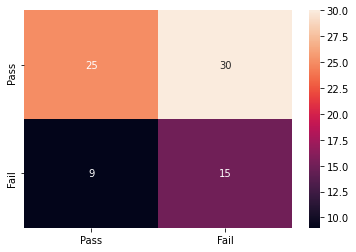

In [ ]:
confusion_math_d = confusion_matrix(matytest, dummy_math_pred, labels=labels)
confusion_por_d = confusion_matrix(porytest, dummy_por_pred, labels=labels)
sns.heatmap(confusion_math_d, annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')

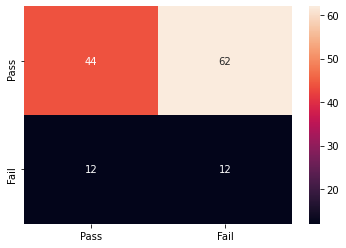

In [ ]:
sns.heatmap(confusion_por_d, annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')

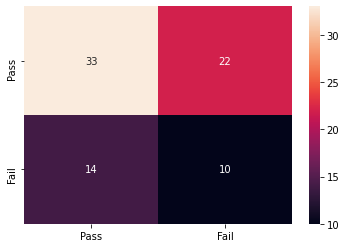

In [ ]:
confusion_math_d_social = confusion_matrix(matytest2, dummy_math_pred2, labels=labels)
confusion_por_d_social = confusion_matrix(porytest2, dummy_por_pred2, labels=labels)
sns.heatmap(confusion_math_d_social, annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')

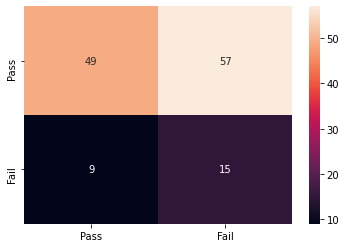

In [ ]:
sns.heatmap(confusion_por_d_social, annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
mat_score_d = cross_val_score(dummy_math, df_mat, y_mat, cv=kfold)
por_score_d = cross_val_score(dummy_por, df_por, y_por, cv=kfold)
print("Cross-Validation Max Score Dummy Classifier (Math) {:.2f}".format(mat_score_d[mat_score_d.argmax()]))
print("Cross-Validation Max Score Dummy Classifier (Por) {:.2f}".format(por_score_d[por_score_d.argmax()]))

mat_score_d2 = cross_val_score(dummy_math_social, df_mat_social, y_mat, cv=kfold)
por_score_d2 = cross_val_score(dummy_por_social, df_por_social, y_por, cv=kfold)
print("Cross-Validation Max Score Dummy Classifier (Math-Social) {:.2f}".format(mat_score_d2.mean()))
print("Cross-Validation Max Score Dummy Classifier (Por-Social) {:.2f}".format(por_score_d2.mean()))

Cross-Validation Max Score Dummy Classifier (Math) 0.60
Cross-Validation Max Score Dummy Classifier (Por) 0.59
Cross-Validation Max Score Dummy Classifier (Math-Social) 0.50
Cross-Validation Max Score Dummy Classifier (Por-Social) 0.48




---


#Random Forest Classifier
###By Matt S.


---



In [ ]:
# Determine best n_estimators parameter for Random Forest Classification
def get_n_estimators(df_X, df_Y):
  Xtrain, Xtest, ytrain, ytest = train_test_split(df_X, df_Y, test_size=0.2, random_state=1)  
  n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 400]
  test_results = []
  test_results2 = []
  for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator)
    rf.fit(Xtrain, ytrain)
    test_f1 = f1_score(ytest, rf.predict(Xtest), labels=labels, pos_label=labels[0])
    test_f1_2 = f1_score(ytest, rf.predict(Xtest), labels=labels, pos_label=labels[1])
    test_results.append(test_f1)
    test_results2.append(test_f1_2)
  plt.plot(n_estimators, test_results, 'b', label="f1 Score")
  plt.plot(n_estimators, test_results2, 'r', label="f1 Score")
  plt.ylabel('F1 Score')
  plt.xlabel('n_estimators')
  plt.show()

In [ ]:
# Determine best n_estimators parameter for Random Forest Classification
def get_max_depth(df_X, df_Y, n_estimators):  
  max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  Xtrain, Xtest, ytrain, ytest = train_test_split(df_X, df_Y, test_size=0.2, random_state=1)  
  test_results  = []
  test_results2 = []
  for estimator in max_depth:
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=estimator)
    rf.fit(Xtrain, ytrain)
    test_f1 = f1_score(ytest, rf.predict(Xtest), labels=labels, pos_label=labels[0])
    test_f2 = f1_score(ytest, rf.predict(Xtest), labels=labels, pos_label=labels[1])
    test_results.append(test_f1)
    test_results2.append(test_f2)
  plt.plot(max_depth, test_results, 'b', label="f1 Score")

  plt.ylabel('F1 Score')
  plt.xlabel('max_depth')
  plt.show()

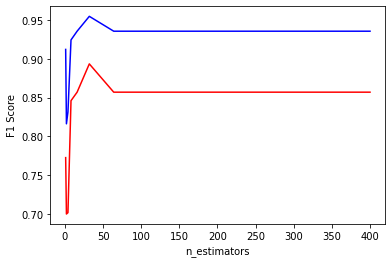

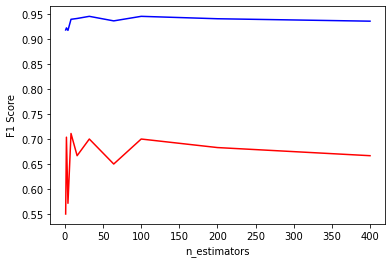

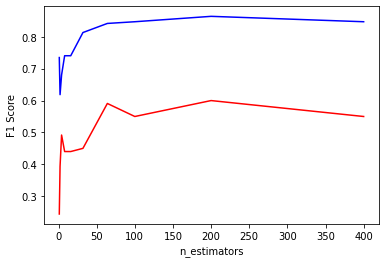

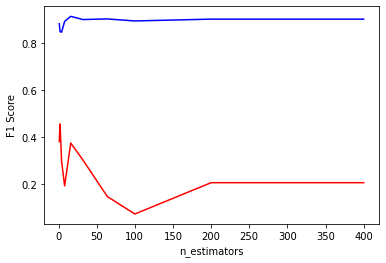

In [ ]:
get_n_estimators(df_mat, y_mat)
get_n_estimators(df_por, y_por)
get_n_estimators(df_mat_social, y_mat)
get_n_estimators(df_por_social, y_por)

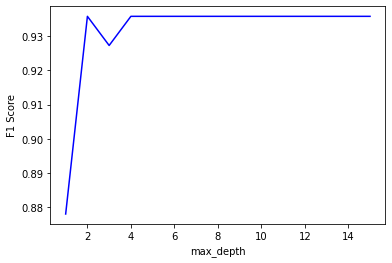

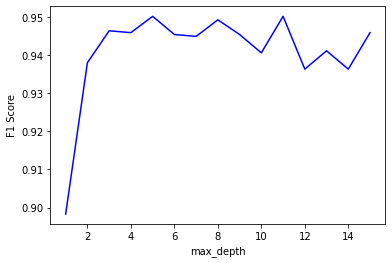

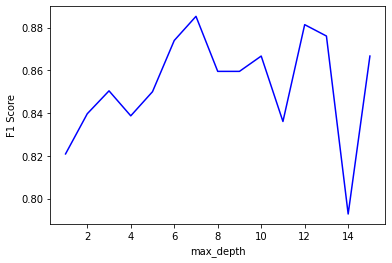

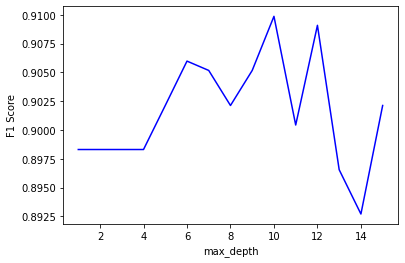

In [ ]:
get_max_depth(df_mat, y_mat, 100)
get_max_depth(df_por, y_por, 100)
get_max_depth(df_mat_social, y_mat, 100)
get_max_depth(df_por_social, y_por, 100)

In [ ]:
# Generate, fit, and test RandomForestClassifier for the Math and Portuguese data sets.
mat_rf = RandomForestClassifier(max_features='sqrt', max_depth=9, n_estimators=100)
por_rf = RandomForestClassifier(max_features='sqrt', max_depth=9, n_estimators=100)

mat_rf.fit(matXtrain, matytrain)
por_rf.fit(porXtrain, porytrain)

mat_pred_rf = mat_rf.predict(matXtest)
por_pred_rf = por_rf.predict(porXtest)

mat_rf_social = RandomForestClassifier(max_features='sqrt', max_depth=9, n_estimators=100)
por_rf_social = RandomForestClassifier(max_features='sqrt', max_depth=9, n_estimators=100)

mat_rf_social.fit(matXtrain2, matytrain2)
por_rf_social.fit(porXtrain2, porytrain2)

mat_pred_rf_social = mat_rf_social.predict(matXtest2)
por_pred_rf_social = por_rf_social.predict(porXtest2)

Confusion Matrix - Math (All Predictors)


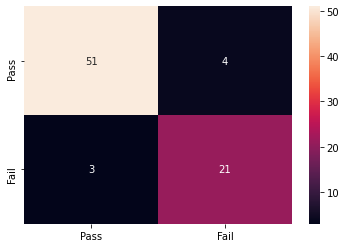

In [ ]:
confusion_math = confusion_matrix(matytest, mat_pred_rf, labels=labels)
confusion_por = confusion_matrix(porytest, por_pred_rf, labels=labels)
sns.heatmap(confusion_math, annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')
print("Confusion Matrix - Math (All Predictors)")

Confusion Matrix - Portuguese (All Predictors)


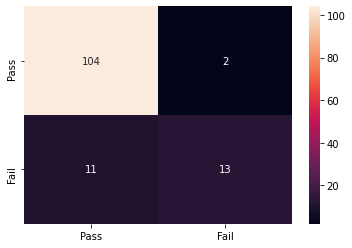

In [ ]:
sns.heatmap(confusion_por, annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')
print("Confusion Matrix - Portuguese (All Predictors)")

Confusion Matrix - Math (Without G1/G2 Predictors)


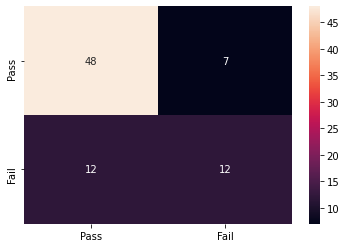

In [ ]:
confusion_math2 = confusion_matrix(matytest2, mat_pred_rf_social, labels=labels)
confusion_por2 = confusion_matrix(porytest2, por_pred_rf_social, labels=labels)
sns.heatmap(confusion_math2, annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')
print("Confusion Matrix - Math (Without G1/G2 Predictors)")

Confusion Matrix - Portuguese (Without G1/G2 Predictors)


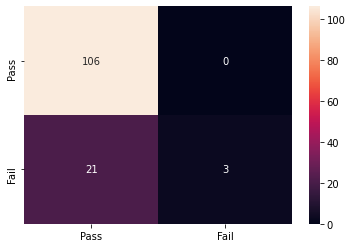

In [ ]:
sns.heatmap(confusion_por2, annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')
print("Confusion Matrix - Portuguese (Without G1/G2 Predictors)")

In [ ]:
print("Math - Random Forest (All predictor) Classication Report")
print(classification_report(matytest, mat_pred_rf, labels=labels, target_names=labels))
print("Portuguese - Random Forest (All predictor) Classication Report")
print(classification_report(porytest, por_pred_rf, labels=labels, target_names=labels))

print("Math - Random Forest (Without G1/G2) Classication Report")
print(classification_report(matytest2, mat_pred_rf_social, labels=labels, target_names=labels))
print("Portuguese - Random Forest (Without G1/G2) Classication Report")
print(classification_report(porytest2, por_pred_rf_social, labels=labels, target_names=labels))

Math - Random Forest (All predictor) Classication Report
              precision    recall  f1-score   support

        Pass       0.94      0.93      0.94        55
        Fail       0.84      0.88      0.86        24

    accuracy                           0.91        79
   macro avg       0.89      0.90      0.90        79
weighted avg       0.91      0.91      0.91        79

Portuguese - Random Forest (All predictor) Classication Report
              precision    recall  f1-score   support

        Pass       0.90      0.98      0.94       106
        Fail       0.87      0.54      0.67        24

    accuracy                           0.90       130
   macro avg       0.89      0.76      0.80       130
weighted avg       0.90      0.90      0.89       130

Math - Random Forest (Without G1/G2) Classication Report
              precision    recall  f1-score   support

        Pass       0.80      0.87      0.83        55
        Fail       0.63      0.50      0.56        24

    a

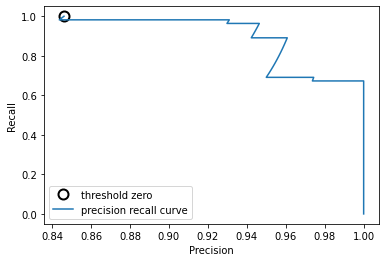

In [ ]:
# Calculate and Show PRC results
precision, recall, thresholds = precision_recall_curve(matytest, mat_rf.predict_proba(matXtest)[:, 1], pos_label=labels[0])
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

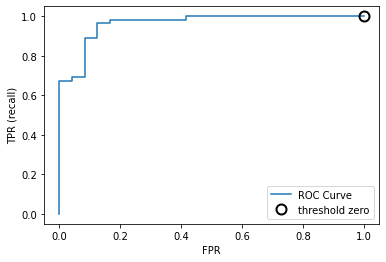

In [ ]:
# Calculate and show ROC Curve
fpr, tpr, thresholds = roc_curve(matytest, mat_rf.predict_proba(matXtest)[:, 1], pos_label=labels[0])

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

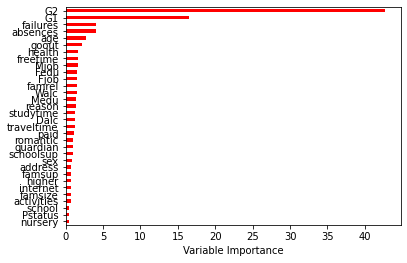

In [ ]:
# Plot the importance rank of each feature in the math dataset 

Importance = pd.DataFrame({'Importance':mat_rf.feature_importances_*100}, 
                          index = df_por.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

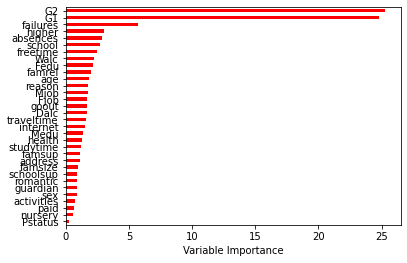

In [ ]:
# Plot the importance rank of each feature in the portugese dataset 

Importance = pd.DataFrame({'Importance':por_rf.feature_importances_*100}, 
                          index = df_por.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

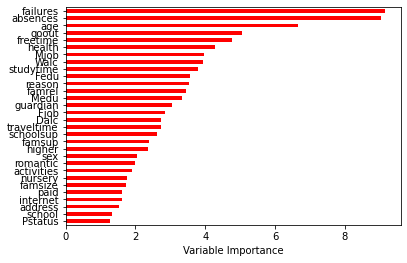

In [ ]:
# Plot the importance rank of each feature in the math social dataset 

Importance = pd.DataFrame({'Importance':mat_rf_social.feature_importances_*100}, 
                          index = df_mat_social.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

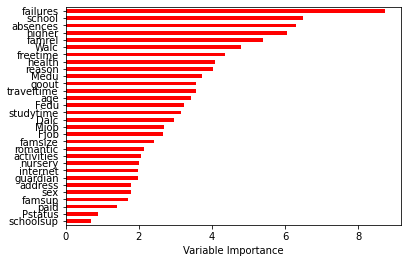

In [ ]:
# Plot the importance rank of each feature in the portuguese social dataset 

Importance = pd.DataFrame({'Importance':por_rf_social.feature_importances_*100}, 
                          index = df_por_social.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [ ]:
rf_mat_score = cross_val_score(mat_rf, df_mat, y_mat, cv=kfold)
rf_por_score = cross_val_score(por_rf, df_por, y_por, cv=kfold)
print("Cross-Validation Max Score (Math) {:.2f}".format(rf_mat_score[mat_score.argmax()]))
print("Cross-Validation Max Score (Por) {:.2f}".format(rf_por_score[por_score.argmax()]))

# Cross Validation Random Forest - Social Only
mat_score_rf_social = cross_val_score(mat_rf_social, df_mat_social, y_mat, cv=kfold)
por_score_rf_social = cross_val_score(por_rf_social, df_por_social, y_por, cv=kfold)
print("Cross-Validation Max Score Random Forest (Math-Social) {:.2f}".format(mat_score_rf_social.mean()))
print("Cross-Validation Max Score Random Forest (Por-Social) {:.2f}".format(por_score_rf_social.mean()))

Cross-Validation Max Score (Math) 0.97
Cross-Validation Max Score (Por) 0.94
Cross-Validation Max Score Random Forest (Math-Social) 0.70
Cross-Validation Max Score Random Forest (Por-Social) 0.84




---

#LDA Classifiers
####By Allison A. 

---



###Linear Discriminant Analysis

In [ ]:
# CREATE LDA CLASSIFIER FOR MATH & POR DATA ####################################
lda1 = LinearDiscriminantAnalysis() 
lda2 = LinearDiscriminantAnalysis()
lda_soc1 = LinearDiscriminantAnalysis()
lda_soc2 = LinearDiscriminantAnalysis()

In [ ]:
# create a LDA classifier w/ G1&G2
math_lda = lda1.fit(matXtrain, matytrain)
por_lda = lda2.fit(porXtrain, porytrain)
# use model to predict test data's y values
math_pred_lda = math_lda.predict(matXtest)
por_pred_lda = por_lda.predict(porXtest)

# create LDA classifier w/out G1&G2 (social)
math_lda_social = lda_soc1.fit(matXtrain2, matytrain2)
por_lda_social = lda_soc2.fit(porXtrain2, porytrain2)
# use model to predict test data's y values
math_pred_lda_social = math_lda_social.predict(matXtest2)
por_pred_lda_social = por_lda_social.predict(porXtest2)

In [ ]:
# print the overall score for each model before feature selection
print("\nLDA Score (Math): {:.2f}".format(math_lda.score(matXtest, matytest)))
print("LDA Score (Por) : {:.2f}".format(por_lda.score(matXtest, matytest)))

print("\nLDA Score (Math) Social: {:.2f}".format(math_lda_social.score(matXtest2, matytest2)))
print("LDA Score (Por) Social: {:.2f}".format(por_lda_social.score(matXtest2, matytest2)))


LDA Score (Math): 0.90
LDA Score (Por) : 0.77

LDA Score (Math) Social: 0.68
LDA Score (Por) Social: 0.73


In [ ]:
# print classification report
print('LDA Classification Report, Math Scores (w/ grades)')
print(classification_report(matytest, math_pred_lda))
print('\nLDA Classification Report, Portuguese Scores (w/ grades)')
print(classification_report(porytest, por_pred_lda))

print('\nLDA Classification Report, Math Scores Social (w/out grades)')
print(classification_report(matytest2, math_pred_lda_social))
print('\nLDA Classification Report, Por Scores Social (w/out grades)')
print(classification_report(porytest2, por_pred_lda_social))

LDA Classification Report, Math Scores (w/ grades)
              precision    recall  f1-score   support

        Fail       0.86      0.79      0.83        24
        Pass       0.91      0.95      0.93        55

    accuracy                           0.90        79
   macro avg       0.89      0.87      0.88        79
weighted avg       0.90      0.90      0.90        79


LDA Classification Report, Portuguese Scores (w/ grades)
              precision    recall  f1-score   support

        Fail       0.83      0.42      0.56        24
        Pass       0.88      0.98      0.93       106

    accuracy                           0.88       130
   macro avg       0.86      0.70      0.74       130
weighted avg       0.87      0.88      0.86       130


LDA Classification Report, Math Scores Social (w/out grades)
              precision    recall  f1-score   support

        Fail       0.48      0.46      0.47        24
        Pass       0.77      0.78      0.77        55

    accurac

In [ ]:
# FORWWARD STEP SUBSET SELECTION ###############################################
# Forward-Step Subset Predictor for LDA classifier
def processSubsetLDA(feature_set, attributes, modelType, dataFrame, yValues,):
    # fit model
    model = modelType.fit(dataFrame[list(feature_set)], yValues)
    # Calculate f1_score
    f1Score = f1_score(y_true=yValues, 
                       y_pred=model.predict(dataFrame[list(feature_set)]), 
                       labels=["Pass", "Fail"], 
                       pos_label="Pass")
    # Record attribute set used to fit the model
    attributes.append(list(feature_set))
    # Return the model and the f1_score
    return {"model":model, "f1Score":f1Score}

def forwardLDA(predictors, modelType, dataFrame, yValues):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in dataFrame.columns if p not in predictors]

    tic = time.time()
    
    results = []    # Dictionary containing model and f1-score
    attributes = [] # 2D list of attributes used for each model 
    for p in remaining_predictors:
        results.append(processSubsetLDA(predictors+[p], attributes, 
                                     modelType, dataFrame, yValues))
    
    # Dataframe of the results for all models generated
    models = pd.DataFrame(results)
    
    # Choose the model with the highest f1_score
    best_model = models.loc[models['f1Score'].idxmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, 
          "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, the set of attributes associated w/ the best model
    return best_model, attributes[models['f1Score'].idxmax()]

In [ ]:
# FS math data (w/ grades)
models_math_lda = pd.DataFrame(columns=["f1Score", "model"])
tic = time.time()
predictors_lda = []               # Which predictors have been used for a model
model_predictors_math_lda = []    # 2D list of the best attributes for each of the best models

# model to perform forward-best subset selection on
model = LinearDiscriminantAnalysis()

bestF1Score = 0
f1_location_math = -1

for i in range(1, len(df_mat.columns)+1):
    models_math_lda.loc[i], predictors_lda = forwardLDA(predictors_lda, model, df_mat, y_mat)
    model_predictors_math_lda.append(predictors_lda)
    if models_math_lda["f1Score"].loc[i] > bestF1Score:
      bestF1Score = models_math_lda["f1Score"].loc[i]
      f1_location_math = i

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

# save best model for ease of access 
best_model_math = models_math_lda["model"].loc[f1_location_math-1]

print("\nBest F1 Score: ", bestF1Score)
print("Location of model: ", f1_location_math)
print("Predictors used: ", model_predictors_math_lda[f1_location_math])

Processed  32 models on 1 predictors in 0.21153783798217773 seconds.
Processed  31 models on 2 predictors in 0.23485469818115234 seconds.
Processed  30 models on 3 predictors in 0.2196657657623291 seconds.
Processed  29 models on 4 predictors in 0.21193575859069824 seconds.
Processed  28 models on 5 predictors in 0.1998605728149414 seconds.
Processed  27 models on 6 predictors in 0.21548891067504883 seconds.
Processed  26 models on 7 predictors in 0.19799208641052246 seconds.
Processed  25 models on 8 predictors in 0.19307661056518555 seconds.
Processed  24 models on 9 predictors in 0.17177772521972656 seconds.
Processed  23 models on 10 predictors in 0.17503738403320312 seconds.
Processed  22 models on 11 predictors in 0.17248773574829102 seconds.
Processed  21 models on 12 predictors in 0.17234134674072266 seconds.
Processed  20 models on 13 predictors in 0.15306806564331055 seconds.
Processed  19 models on 14 predictors in 0.16193628311157227 seconds.
Processed  18 models on 15 pred

In [ ]:
# FS por data (w/ grades)
models_por_lda = pd.DataFrame(columns=["f1Score", "model"])
tic = time.time()
predictors_lda = []               # Which predictors have been used for a model
model_predictors_por_lda = []     # 2D list of the best attributes for each of the best models

# model to perform forward-best subset selection on
model = LinearDiscriminantAnalysis()

bestF1Score = 0
f1_location_por = -1

for i in range(1, len(df_por.columns)+1):
    models_por_lda.loc[i], predictors_lda = forwardLDA(predictors_lda, model, df_por, y_por)
    model_predictors_por_lda.append(predictors_lda)
    if models_por_lda["f1Score"].loc[i] > bestF1Score:
      bestF1Score = models_por_lda["f1Score"].loc[i]
      f1_location_por = i

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

# save best model for ease of access 
best_model_por = models_por_lda["model"].loc[f1_location_por-1]

print("\nBest F1 Score: ", bestF1Score)
print("Location of model: ", f1_location_por)
print("Predictors used: ", model_predictors_por_lda[f1_location_por])

Processed  32 models on 1 predictors in 0.2747182846069336 seconds.
Processed  31 models on 2 predictors in 0.28916454315185547 seconds.
Processed  30 models on 3 predictors in 0.28115296363830566 seconds.
Processed  29 models on 4 predictors in 0.28354763984680176 seconds.
Processed  28 models on 5 predictors in 0.260509729385376 seconds.
Processed  27 models on 6 predictors in 0.2617182731628418 seconds.
Processed  26 models on 7 predictors in 0.25405240058898926 seconds.
Processed  25 models on 8 predictors in 0.25028252601623535 seconds.
Processed  24 models on 9 predictors in 0.24331903457641602 seconds.
Processed  23 models on 10 predictors in 0.2320566177368164 seconds.
Processed  22 models on 11 predictors in 0.2245769500732422 seconds.
Processed  21 models on 12 predictors in 0.21442294120788574 seconds.
Processed  20 models on 13 predictors in 0.21535634994506836 seconds.
Processed  19 models on 14 predictors in 0.32185840606689453 seconds.
Processed  18 models on 15 predicto

In [ ]:
# FS math social data (w/out grades)
models_math_soc_lda = pd.DataFrame(columns=["f1Score", "model"])
tic = time.time()
predictors_lda = []                   # Which predictors have been used for a model
model_predictors_math_soc_lda = []    # 2D list of the best attributes for each of the best models

# model to perform forward-best subset selection on
model = LinearDiscriminantAnalysis()

bestF1Score = 0
f1_location_math_soc = -1

for i in range(1, len(df_mat_social.columns)+1):
    models_math_soc_lda.loc[i], predictors_lda = forwardLDA(predictors_lda, model, df_mat_social, y_mat)
    model_predictors_math_soc_lda.append(predictors_lda)
    if models_math_soc_lda["f1Score"].loc[i] > bestF1Score:
      bestF1Score = models_math_soc_lda["f1Score"].loc[i]
      f1_location_math_soc = i

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

# save best model for ease of access 
best_model_math_soc = models_math_soc_lda["model"].loc[f1_location_math_soc-1]

print("\nBest F1 Score: ", bestF1Score)
print("Location of model: ", f1_location_math_soc)
print("Predictors used: ", model_predictors_math_soc_lda[f1_location_math_soc])

Processed  30 models on 1 predictors in 0.19127130508422852 seconds.
Processed  29 models on 2 predictors in 0.22825407981872559 seconds.
Processed  28 models on 3 predictors in 0.22117280960083008 seconds.
Processed  27 models on 4 predictors in 0.21569204330444336 seconds.
Processed  26 models on 5 predictors in 0.1879110336303711 seconds.
Processed  25 models on 6 predictors in 0.18938136100769043 seconds.
Processed  24 models on 7 predictors in 0.17831206321716309 seconds.
Processed  23 models on 8 predictors in 0.17776274681091309 seconds.
Processed  22 models on 9 predictors in 0.16486644744873047 seconds.
Processed  21 models on 10 predictors in 0.16372275352478027 seconds.
Processed  20 models on 11 predictors in 0.15761685371398926 seconds.
Processed  19 models on 12 predictors in 0.15674853324890137 seconds.
Processed  18 models on 13 predictors in 0.1501607894897461 seconds.
Processed  17 models on 14 predictors in 0.13693833351135254 seconds.
Processed  16 models on 15 pred

In [ ]:
# FS por social data (w/out grades)
models_por_soc_lda = pd.DataFrame(columns=["f1Score", "model"])
tic = time.time()
predictors_lda = []                   # Which predictors have been used for a model
model_predictors_por_soc_lda = []     # 2D list of the best attributes for each of the best models

# model to perform forward-best subset selection on
model = LinearDiscriminantAnalysis()

bestF1Score = 0
f1_location_por_soc = -1

for i in range(1, len(df_por_social.columns)+1):
    models_por_soc_lda.loc[i], predictors_lda = forwardLDA(predictors_lda, model, df_por_social, y_por)
    model_predictors_por_soc_lda.append(predictors_lda)
    if models_por_soc_lda["f1Score"].loc[i] > bestF1Score:
      bestF1Score = models_por_soc_lda["f1Score"].loc[i]
      f1_location_por_soc = i

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

# save best model for ease of access 
best_model_por_soc = models_por_soc_lda["model"].loc[f1_location_por_soc-1]

print("\nBest F1 Score: ", bestF1Score)
print("Location of model: ", f1_location_por_soc)
print("Predictors used: ", model_predictors_por_soc_lda[f1_location_por_soc])

Processed  30 models on 1 predictors in 0.26379871368408203 seconds.
Processed  29 models on 2 predictors in 0.25951170921325684 seconds.
Processed  28 models on 3 predictors in 0.27211475372314453 seconds.
Processed  27 models on 4 predictors in 0.2544240951538086 seconds.
Processed  26 models on 5 predictors in 0.2415294647216797 seconds.
Processed  25 models on 6 predictors in 0.24507427215576172 seconds.
Processed  24 models on 7 predictors in 0.24422478675842285 seconds.
Processed  23 models on 8 predictors in 0.23427748680114746 seconds.
Processed  22 models on 9 predictors in 0.22500109672546387 seconds.
Processed  21 models on 10 predictors in 0.21132254600524902 seconds.
Processed  20 models on 11 predictors in 0.202897310256958 seconds.
Processed  19 models on 12 predictors in 0.19437623023986816 seconds.
Processed  18 models on 13 predictors in 0.19501399993896484 seconds.
Processed  17 models on 14 predictors in 0.2835419178009033 seconds.
Processed  16 models on 15 predict

In [ ]:
# get predictions of new best models 
math_pred_lda = best_model_math.predict(matXtest)
por_pred_lda = best_model_por.predict(porXtest)
math_pred_lda_social = best_model_math_soc.predict(matXtest2)
por_pred_lda_social = best_model_por_soc.predict(porXtest2)

In [ ]:
# print classification report
print('LDA Classification Report, Math Scores (w/ grades)')
print(classification_report(matytest, math_pred_lda))
print('\nLDA Classification Report, Portuguese Scores (w/ grades)')
print(classification_report(porytest, por_pred_lda))

print('\nLDA Classification Report, Math Scores Social (w/out grades)')
print(classification_report(matytest2, math_pred_lda_social))
print('\nLDA Classification Report, Portuguese Scores Social (w/out grades)')
print(classification_report(porytest2, por_pred_lda_social))

LDA Classification Report, Math Scores (w/ grades)
              precision    recall  f1-score   support

        Fail       0.41      0.38      0.39        24
        Pass       0.74      0.76      0.75        55

    accuracy                           0.65        79
   macro avg       0.57      0.57      0.57        79
weighted avg       0.64      0.65      0.64        79


LDA Classification Report, Portuguese Scores (w/ grades)
              precision    recall  f1-score   support

        Fail       0.29      0.08      0.13        24
        Pass       0.82      0.95      0.88       106

    accuracy                           0.79       130
   macro avg       0.55      0.52      0.51       130
weighted avg       0.72      0.79      0.74       130


LDA Classification Report, Math Scores Social (w/out grades)
              precision    recall  f1-score   support

        Fail       0.29      0.21      0.24        24
        Pass       0.69      0.78      0.74        55

    accurac

In [ ]:
# feature selection performed worse, reset prediction variables 
math_pred_lda = math_lda.predict(matXtest)
por_pred_lda = por_lda.predict(porXtest)
math_pred_lda_social = math_lda_social.predict(matXtest2)
por_pred_lda_social = por_lda_social.predict(porXtest2)

In [ ]:
# print the overall score for each model
print("\nLDA Score (Math): {:.2f}".format(math_lda.score(matXtest, matytest)))
print("LDA Score (Por) : {:.2f}".format(por_lda.score(matXtest, matytest)))

print("\nLDA Score (Math) Social: {:.2f}".format(math_lda_social.score(matXtest2, matytest2)))
print("LDA Score (Por) Social: {:.2f}".format(por_lda_social.score(matXtest2, matytest2)))


LDA Score (Math): 0.90
LDA Score (Por) : 0.77

LDA Score (Math) Social: 0.68
LDA Score (Por) Social: 0.73



Math CM LDA (w/ grades): 


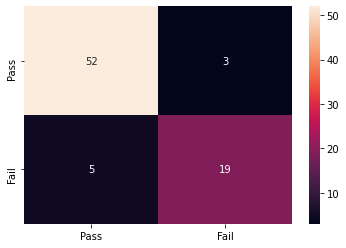

In [ ]:
# create the confusion matricies
cm_math_lda = confusion_matrix(matytest, math_pred_lda, labels=labels)
cm_por_lda = confusion_matrix(porytest, por_pred_lda, labels=labels)
cm_math_lda_social = confusion_matrix(matytest2, math_pred_lda_social, labels=labels)
cm_por_lda_social = confusion_matrix(porytest2, por_pred_lda_social, labels=labels)

# show the heat maps for each confusion matrix
print("\nMath CM LDA (w/ grades): ")
sns.heatmap(cm_math_lda, annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')


Portuguese CM LDA (w/ grades): 


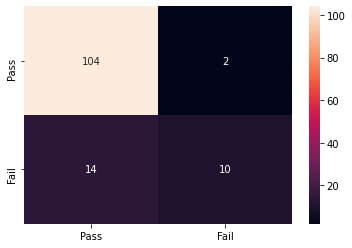

In [ ]:
print("\nPortuguese CM LDA (w/ grades): ")
sns.heatmap(cm_por_lda, annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')


Math CM LDA Social (w/out grades): 


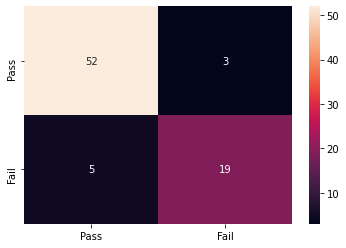

In [ ]:
print("\nMath CM LDA Social (w/out grades): ")
sns.heatmap(cm_math_lda, annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')


Portuguese CM LDA Social (w/out grades): 


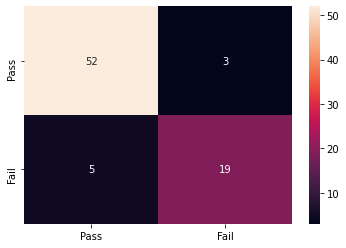

In [ ]:
print("\nPortuguese CM LDA Social (w/out grades): ")
sns.heatmap(cm_math_lda, annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')

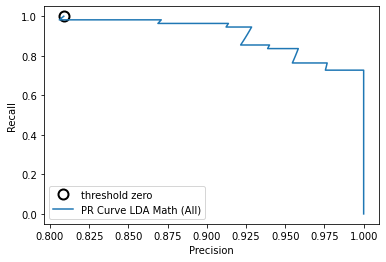

In [ ]:
# Calculate and Show PRC results
precision, recall, thresholds = precision_recall_curve(matytest, math_lda.predict_proba(matXtest)[:, 1], pos_label=labels[0])
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(precision, recall, label="PR Curve LDA Math (All)")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

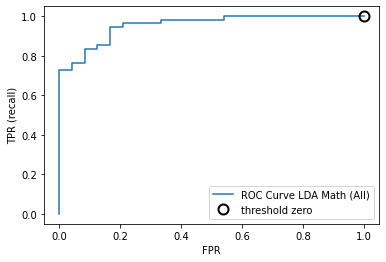

In [ ]:
# Calculate and show ROC Curve
fpr, tpr, thresholds = roc_curve(matytest, math_lda.predict_proba(matXtest)[:, 1], pos_label=labels[0])

plt.plot(fpr, tpr, label="ROC Curve LDA Math (All)")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

In [ ]:
# ASSESS THE LDA MODEL (FOR MATH & POR) USING K-FOLD CV ########################
  # assess the adequacy of using the LDA model on these datasets 

# calculate k-fold cross validation on the math and por models (w/ grades)
kfold = KFold(n_splits=10, shuffle=True)
math_lda_cv_scores = cross_val_score(math_lda, df_mat, y_mat, cv=kfold)
por_lda_cv_scores = cross_val_score(por_lda, df_por, y_por, cv=kfold)

# print scores and mean of scores of each
print("Cross-validation scores Math:\n{}".format(math_lda_cv_scores))
print("Mean: {}".format(math_lda_cv_scores.mean()))
print("\nCross-validation scores Portugese:\n{}".format(por_lda_cv_scores))
print("Mean: {}".format(por_lda_cv_scores.mean()))

Cross-validation scores Math:
[0.9        0.8        0.8        0.875      0.8        0.94871795
 0.97435897 0.97435897 0.87179487 0.92307692]
Mean: 0.8867307692307692

Cross-validation scores Portugese:
[0.90769231 0.89230769 0.87692308 0.92307692 0.90769231 0.92307692
 0.89230769 0.93846154 0.90769231 0.9375    ]
Mean: 0.9106730769230771


In [ ]:
# calculate k-fold cross validation on the math and por SOCIAL models (w/out grades)
kfold = KFold(n_splits=10, shuffle=True)
math_soc_lda_cv_scores = cross_val_score(math_lda_social, df_mat_social, y_mat, cv=kfold)
por_soc_lda_cv_scores = cross_val_score(por_lda_social, df_por_social, y_por, cv=kfold)

# print scores and mean of scores of each
print("Cross-validation scores Math Social:\n{}".format(math_soc_lda_cv_scores))
print("Mean: {}".format(math_soc_lda_cv_scores.mean()))
print("\nCross-validation scores Portugese (Social):\n{}".format(por_soc_lda_cv_scores))
print("Mean: {}".format(por_soc_lda_cv_scores.mean()))

Cross-validation scores Math Social:
[0.675      0.675      0.675      0.7        0.6        0.66666667
 0.69230769 0.71794872 0.76923077 0.56410256]
Mean: 0.6735256410256409

Cross-validation scores Portugese (Social):
[0.81538462 0.86153846 0.84615385 0.87692308 0.84615385 0.83076923
 0.78461538 0.90769231 0.87692308 0.890625  ]
Mean: 0.8536778846153847




---


#Support Vector Machines
####By David H. 


---



In [ ]:
#Find best parameters for models
#WARNING: this takes forever to compile!
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear','poly','rbf']} 
  
gridMat = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1_micro',return_train_score=True)
gridPor = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1_micro',return_train_score=True)
  
#Fitting the model for grid search
gridMat.fit(matXtrain, matytrain)
gridPor.fit(porXtrain, porytrain)

KeyboardInterrupt: ignored

In [ ]:
#Print best parameter after tuning
print(gridMat.best_params_)
print(gridPor.best_params_)
  
#Print how our model looks after hyper-parameter tuning
print(gridMat.best_estimator_)
print(gridPor.best_estimator_)

#To prevent having to recomipile the above cells, the results of gridMat.best_params_ and gridPor.best_params_ are:
# {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
# {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [ ]:
#And here are SVC's based on these parameters:

svcMat = SVC(kernel = 'rbf', C = 100, gamma = 0.001)
svcMat.fit(matXtrain,matytrain)
svcPor = SVC(kernel = 'rbf', C = 10, gamma = 0.01)
svcPor.fit(porXtrain,porytrain)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
#Find best parameters for social model (no G1/G2)

#WARNING: this takes forever to compile!
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear','poly','rbf']} 
  
gridMatSoc = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1_micro',return_train_score=True)
gridPorSoc = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1_micro',return_train_score=True)
  
#Fitting the model for grid search
gridMatSoc.fit(matXtrain2, matytrain2)
gridPorSoc.fit(porXtrain2, porytrain2)

In [ ]:
#Print best parameter after tuning
print(gridMatSoc.best_params_)
print(gridPorSoc.best_params_)
  
#Print how our model looks after hyper-parameter tuning
print(gridMatSoc.best_estimator_)
print(gridPorSoc.best_estimator_)

#To prevent having to recomipile the above cells, the results of gridMat.best_params_ and gridPor.best_params_ are:
#{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
#{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

In [ ]:
#And here are SVC's based on these parameters:

svcMatSoc = SVC(kernel = 'linear', C = 0.1, gamma = 1)
svcMatSoc.fit(matXtrain2,matytrain2)
svcPorSoc = SVC(kernel = 'rbf', C = 100, gamma = 0.001)
svcPorSoc.fit(porXtrain2,porytrain2)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Confusion matrix for math (G1 and G2 included)


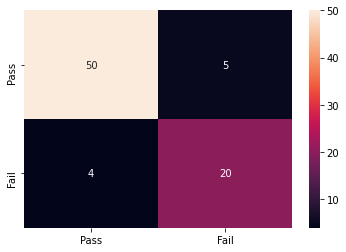

In [ ]:
#Confusion matrix for math (G1 and G2 included)

cmMat = confusion_matrix(matytest, svcMat.predict(matXtest), labels=labels)
sns.heatmap(cmMat, annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')
print('Confusion matrix for math (G1 and G2 included)')

Confusion matrix for Portuguese (G1 and G2 included)


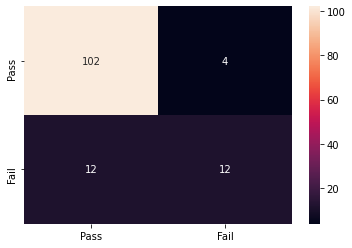

In [ ]:
#Confusion matrix for portuguese (G1 and G2 included)
cmPor = confusion_matrix(porytest, svcPor.predict(porXtest),labels=labels)
sns.heatmap()
print('Confusion matrix for Portuguese (G1 and G2 included)')

Confusion matrix for Math (G1 and G2 excluded)


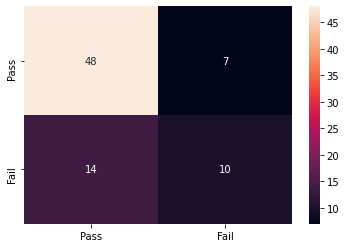

In [ ]:
#Confusion matrix for math (NO G1 and G2)
cmMatSoc = confusion_matrix(matytest2, svcMatSoc.predict(matXtest2), labels=labels)
sns.heatmap(cmMatSoc, annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')
print('Confusion matrix for Math (G1 and G2 excluded)')

Confusion matrix for Portuguese (G1 and G2 excluded)


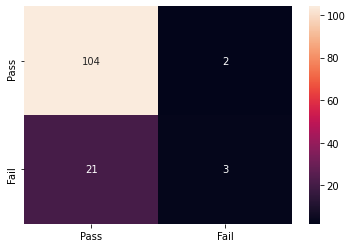

In [ ]:
#Confusion matrix for Portuguese (NO G1 and G2)
cmPorSoc = confusion_matrix(porytest2, svcPorSoc.predict(porXtest2), labels=labels)
sns.heatmap(cmPorSoc, annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')
print('Confusion matrix for Portuguese (G1 and G2 excluded)')

In [ ]:
#Print out classification reports
svcMat_predictions = svcMat.predict(matXtest)
svcPor_predictions = svcPor.predict(porXtest)
svcMatSoc_predictions = svcMatSoc.predict(matXtest2)
svcPorSoc_predictions = svcPorSoc.predict(porXtest2)
  
# print classification report
print('Classification Report, Math Scores (G1, G2 included)')
print(classification_report(matytest, svcMat_predictions))
print('Classification Report, Portuguese Scores (G1, G2 included)')
print(classification_report(porytest, svcPor_predictions))
print('Classification Report, Math Scores (G1, G2 NOT included)')
print(classification_report(matytest2, svcMatSoc_predictions))
print('Classification Report, Portuguese Scores (G1, G2 NOT included)')
print(classification_report(porytest2, svcPorSoc_predictions))

Classification Report, Math Scores (G1, G2 included)
              precision    recall  f1-score   support

        Fail       0.80      0.83      0.82        24
        Pass       0.93      0.91      0.92        55

    accuracy                           0.89        79
   macro avg       0.86      0.87      0.87        79
weighted avg       0.89      0.89      0.89        79

Classification Report, Portuguese Scores (G1, G2 included)
              precision    recall  f1-score   support

        Fail       0.75      0.50      0.60        24
        Pass       0.89      0.96      0.93       106

    accuracy                           0.88       130
   macro avg       0.82      0.73      0.76       130
weighted avg       0.87      0.88      0.87       130

Classification Report, Math Scores (G1, G2 NOT included)
              precision    recall  f1-score   support

        Fail       0.59      0.42      0.49        24
        Pass       0.77      0.87      0.82        55

    accuracy 

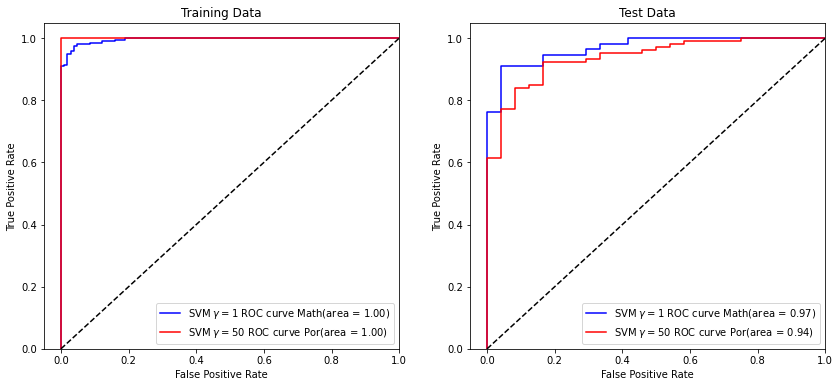

In [ ]:
#ROC curves
#Create array of 0/1's instead of Fail/Pass to accomodate plotting
yMatTestNums = [0 if x == 'Fail' else 1 for x in matytest] 
yMatTrainNums = [0 if x == 'Fail' else 1 for x in matytrain]

yPorTestNums = [0 if x == 'Fail' else 1 for x in porytest] 
yPorTrainNums = [0 if x == 'Fail' else 1 for x in porytrain]

y_train_scoreMat = svcMat.decision_function(matXtrain)
y_train_scorePor = svcPor.decision_function(porXtrain)

false_pos_rateMat, true_pos_rateMat, _ = roc_curve(yMatTrainNums, y_train_scoreMat)
roc_aucMat = auc(false_pos_rateMat, true_pos_rateMat)

false_pos_ratePor, true_pos_ratePor, _ = roc_curve(yPorTrainNums, y_train_scorePor)
roc_aucPor = auc(false_pos_ratePor, true_pos_ratePor)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(false_pos_rateMat, true_pos_rateMat, label='SVM $\gamma = 1$ ROC curve Math(area = %0.2f)' % roc_aucMat, color='b')
ax1.plot(false_pos_ratePor, true_pos_ratePor, label='SVM $\gamma = 50$ ROC curve Por(area = %0.2f)' % roc_aucPor, color='r')
ax1.set_title('Training Data')

y_test_scoreMat = svcMat.decision_function(matXtest)
y_test_scorePor = svcPor.decision_function(porXtest)

false_pos_rateMat, true_pos_rateMat, _ = roc_curve(yMatTestNums, y_test_scoreMat)
roc_aucMat = auc(false_pos_rateMat, true_pos_rateMat)

false_pos_ratePor, true_pos_ratePor, _ = roc_curve(yPorTestNums, y_test_scorePor)
roc_aucPor = auc(false_pos_ratePor, true_pos_ratePor)

ax2.plot(false_pos_rateMat, true_pos_rateMat, label='SVM $\gamma = 1$ ROC curve Math(area = %0.2f)' % roc_aucMat, color='b')
ax2.plot(false_pos_ratePor, true_pos_ratePor, label='SVM $\gamma = 50$ ROC curve Por(area = %0.2f)' % roc_aucPor, color='r')
ax2.set_title('Test Data')

for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

In [ ]:
#Cross-validation and boxplot

# Cross Validation - Social + G1 + G2
kfold = KFold(n_splits=10, shuffle=True)
SVCmat_score = cross_val_score(svcMat, df_mat, y_mat, cv=kfold)
SVCpor_score = cross_val_score(svcPor, df_por, y_por, cv=kfold)
print("Cross-Validation Max Score SVC Math {:.2f}".format(SVCmat_score[SVCmat_score.argmax()]))
print("Cross-Validation Max Score SVC Por {:.2f}".format(SVCpor_score[SVCpor_score.argmax()]))


Cross-Validation Max Score SVC Math 0.97
Cross-Validation Max Score SVC Por 0.97


In [ ]:
# Cross Validation - Social Only
kfold = KFold(n_splits=10, shuffle=True)
SVCmat_score2 = cross_val_score(svcMatSoc, df_mat_social, y_mat, cv=kfold)
SVCpor_score2 = cross_val_score(svcPorSoc, df_por_social, y_por, cv=kfold)
print("Cross-Validation Max Score SVC (Math-Social) {:.2f}".format(SVCmat_score2[SVCmat_score2.argmax()]))
print("Cross-Validation Max Score SVC (Por-Social) {:.2f}".format(SVCpor_score2[SVCpor_score2.argmax()]))

mat_score_d2 = cross_val_score(dummy_math_social, df_mat_social, y_mat, cv=kfold)
por_score_d2 = cross_val_score(dummy_por_social, df_por_social, y_por, cv=kfold)
print("Cross-Validation Max Score Dummy Classifier (Math-Social) {:.2f}".format(mat_score_d2[mat_score_d2.argmax()]))
print("Cross-Validation Max Score Dummy Classifier (Por-Social) {:.2f}".format(por_score_d2[por_score_d2.argmax()]))

Cross-Validation Max Score SVC (Math-Social) 0.82
Cross-Validation Max Score SVC (Por-Social) 0.91
Cross-Validation Max Score Dummy Classifier (Math-Social) 0.68
Cross-Validation Max Score Dummy Classifier (Por-Social) 0.60


In [ ]:
#smaller DF with continuous variables (also, G1 and G2 are known to be significant)
smallMat = [df_mat.age,df_mat.G1,df_mat.G2]
smallPor = [df_por.age,df_por.G1,df_por.G2]

smallMatDF = np.array(smallMat)
smallMatDF = np.transpose(smallMatDF)
smallPorDF = np.array(smallPor)
smallPorDF = np.transpose(smallPorDF)
print(smallMatDF.shape)
print(smallPorDF.shape)

#new test, train with smallDFs
smatXtrain, smatXtest, smatytrain, smatytest = train_test_split(smallMatDF, y_mat, test_size=0.2, random_state=1)
sporXtrain, sporXtest, sporytrain, sporytest = train_test_split(smallPorDF, y_por, test_size=0.2, random_state=1)

(395, 3)
(649, 3)


In [ ]:
#Linear model (just for math), for smallDF (it appears that a linear model will be a good separator, looking at the graph)

linparam_grid = {'C': [0.01, 0.01, 0.1, 1, 5, 10, 100]} 
  
smallgrid = GridSearchCV(SVC(kernel = 'linear'), linparam_grid, cv=10, scoring='f1_micro',return_train_score=True)
  
# fitting the model for grid search
smallgrid.fit(smatXtrain, smatytrain)

# print best parameter after tuning
print(smallgrid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(smallgrid.best_estimator_)
smallgrid_predictions = smallgrid.predict(smatXtest)
  
# print classification report
print("\nClassification Report for Linear SVC (age/G1/G2)")
print(classification_report(smatytest, smallgrid_predictions))

#NOTE, the outcomes from this graph are worse than the more complex models, but we can more easily visualize this data

{'C': 5}
SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Classification Report for Linear SVC (age/G1/G2)
              precision    recall  f1-score   support

        Fail       0.87      0.83      0.85        24
        Pass       0.93      0.95      0.94        55

    accuracy                           0.91        79
   macro avg       0.90      0.89      0.89        79
weighted avg       0.91      0.91      0.91        79



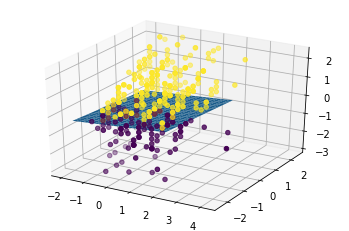

In [ ]:
#Recreate model from above, in format that permits plotting
svcsmall = SVC(kernel = 'linear', C = 5)
svcsmall.fit(smatXtrain, smatytrain)


#Function for separating plane
z = lambda x,y: (-svcsmall.intercept_[0]-svcsmall.coef_[0][0]*x-svcsmall.coef_[0][1]*y) / svcsmall.coef_[0][2]


#Plot stuff
tmp = np.linspace(-2,2,51)
x,y = np.meshgrid(tmp,tmp)


ax = plt.axes(projection='3d')
#Need 0/1 instead of Pass/Fail
yMatBin = [0 if x == 'Fail' else 1 for x in y_mat]

# Data for three-dimensional scattered points
xdata = df_mat.age
ydata = df_mat.G1
zdata = df_mat.G2
ax.scatter3D(xdata, ydata, zdata, c=yMatBin);
ax.plot_surface(x, y, z(x,y))



---


# K-Nearest-Neighbors
By Nat Arney


---



BEST VALUE OF K (Math): 13
BEST VALUE OF K (Port): 1


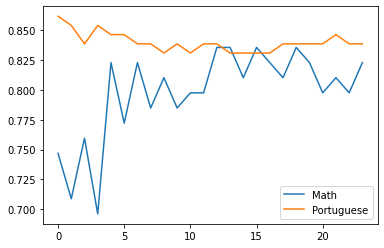

In [ ]:
# Find best value of k (All Parameters)
def returnScore(k, xtrain, xtest, ytrain, ytest):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(xtrain, ytrain)
  return knn.score(xtest, ytest)

knn_mat_result = [*map(lambda i:returnScore(i,matXtrain, matXtest, matytrain, matytest), range(1,25))]
knn_por_result = [*map(lambda i:returnScore(i,porXtrain, porXtest, porytrain, porytest), range(1,25))]
mat_best_k = np.argmax(knn_mat_result) + 1
por_best_k = np.argmax(knn_por_result) + 1

plt.plot(knn_mat_result,label="Math")
plt.plot(knn_por_result,label="Portuguese")
plt.legend()

print('BEST VALUE OF K (Math):',mat_best_k)
print('BEST VALUE OF K (Port):',por_best_k)

BEST VALUE OF K (Math): 9
BEST VALUE OF K (Port): 4


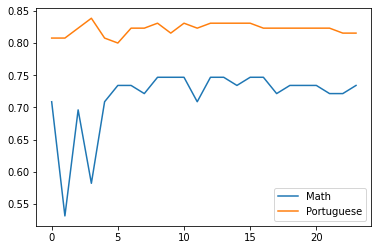

In [ ]:
# Find best value of k (Social Factors)
def returnScore(k, xtrain, xtest, ytrain, ytest):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(xtrain, ytrain)
  return knn.score(xtest, ytest)

knn_mat_result2 = [*map(lambda i:returnScore(i,matXtrain2, matXtest2, matytrain2, matytest2), range(1,25))]
knn_por_result2 = [*map(lambda i:returnScore(i,porXtrain2, porXtest2, porytrain2, porytest2), range(1,25))]
mat_best_k2 = np.argmax(knn_mat_result2) + 1
por_best_k2 = np.argmax(knn_por_result2) + 1

plt.plot(knn_mat_result2,label="Math")
plt.plot(knn_por_result2,label="Portuguese")
plt.legend()

print('BEST VALUE OF K (Math):',mat_best_k2)
print('BEST VALUE OF K (Port):',por_best_k2)

In [ ]:
# Initialize & fit knn_mat, knn_por

# All
knn_mat = KNeighborsClassifier(n_neighbors=mat_best_k)
knn_por = KNeighborsClassifier(n_neighbors=por_best_k)

knn_mat.fit(matXtrain,matytrain)
knn_por.fit(porXtrain,porytrain)

# Social Factors
knn_mat2 = KNeighborsClassifier(n_neighbors=mat_best_k2)
knn_por2 = KNeighborsClassifier(n_neighbors=por_best_k2)

knn_mat2.fit(matXtrain2,matytrain2)
knn_por2.fit(porXtrain2,porytrain2)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [ ]:
# Predictions
knn_mat_pred = knn_mat.predict(matXtest)
knn_por_pred = knn_por.predict(porXtest)

knn_mat_pred2 = knn_mat2.predict(matXtest2)
knn_por_pred2 = knn_por2.predict(porXtest2)

# Scores
print("KNN Score (Math, All): {:.2f}".format(knn_mat.score(matXtest,matytest)))
print("KNN Score (Port, All): {:.2f}".format(knn_por.score(porXtest,porytest)))
print()
print("KNN Score (Math, Social): {:.2f}".format(knn_mat2.score(matXtest2,matytest2)))
print("KNN Score (Port, Social): {:.2f}".format(knn_por2.score(porXtest2,porytest2)))

KNN Score (Math, All): 0.84
KNN Score (Port, All): 0.86

KNN Score (Math, Social): 0.75
KNN Score (Port, Social): 0.84


In [ ]:
# F1 Score
print("KNN F1 Score (Math, All): {:.2f}".format(f1_score(matytest,knn_mat_pred,labels=labels,pos_label="Pass")))
print("KNN F1 Score (Port, All): {:.2f}".format(f1_score(porytest,knn_por_pred,labels=labels,pos_label="Pass")))
print()
print("KNN F1 Score (Math, Social): {:.2f}".format(f1_score(matytest2,knn_mat_pred2,labels=labels,pos_label="Pass")))
print("KNN F1 Score (Port, Social): {:.2f}".format(f1_score(porytest2,knn_por_pred2,labels=labels,pos_label="Pass")))

KNN F1 Score (Math, All): 0.89
KNN F1 Score (Port, All): 0.92

KNN F1 Score (Math, Social): 0.84
KNN F1 Score (Port, Social): 0.90


In [ ]:
# Confusion Matrix

# All
knn_mat_matrix = confusion_matrix(matytest,knn_mat_pred,labels=labels)
knn_por_matrix = confusion_matrix(porytest,knn_por_pred,labels=labels)

print("KNN Math Matrix (All)\n",knn_mat_matrix)
print("KNN Port. Matrix (All)\n",knn_por_matrix)

# Social
knn_mat_matrix2 = confusion_matrix(matytest2,knn_mat_pred2,labels=labels)
knn_por_matrix2 = confusion_matrix(porytest2,knn_por_pred2,labels=labels)

print("KNN Math Matrix (Social)\n",knn_mat_matrix2)
print("KNN Port. Matrix (Social)\n",knn_por_matrix2)

KNN Math Matrix (All)
 [[53  2]
 [11 13]]
KNN Port. Matrix (All)
 [[103   3]
 [ 15   9]]
KNN Math Matrix (Social)
 [[51  4]
 [16  8]]
KNN Port. Matrix (Social)
 [[98  8]
 [13 11]]


KNN Math Matrix (G1 + G2 Included)


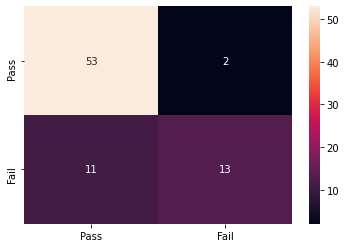

In [ ]:
sns.heatmap(knn_mat_matrix,annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')
print("KNN Math Matrix (G1 + G2 Included)")

KNN Portuguese Matrix (G1 + G2 Included)


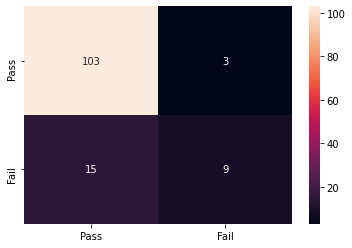

In [ ]:
sns.heatmap(knn_por_matrix,annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')
print("KNN Portuguese Matrix (G1 + G2 Included)")

KNN Math Matrix (G1 + G2 Excluded)


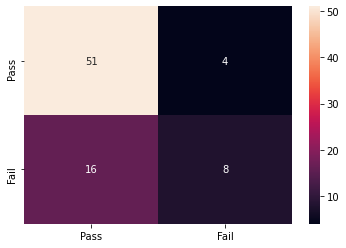

In [ ]:
sns.heatmap(knn_mat_matrix2,annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')
print("KNN Math Matrix (G1 + G2 Excluded)")

KNN Portuguese Matrix (G1 + G2 Excluded)


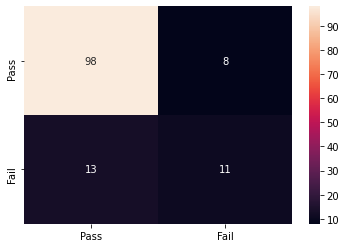

In [ ]:
sns.heatmap(knn_por_matrix2,annot=True, cbar=True, xticklabels=labels, yticklabels=labels, fmt='g')
print("KNN Portuguese Matrix (G1 + G2 Excluded)")

KNN PRC (Math, Grades)


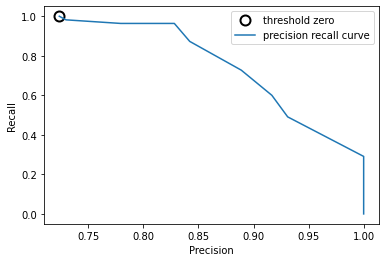

In [ ]:
# Calculate and Show KNN PRC results (Math, Grades)
precision, recall, thresholds = precision_recall_curve(matytest, knn_mat.predict_proba(matXtest)[:, 1], pos_label="Pass")
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

print("KNN PRC (Math, Grades)")

KNN PRC (Portuguese, Grades)


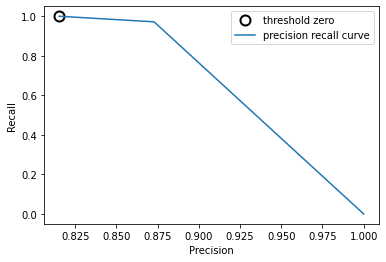

In [ ]:
# Calculate and Show KNN PRC results (Portuguese, Grades)
precision, recall, thresholds = precision_recall_curve(porytest, knn_por.predict_proba(porXtest)[:, 1], pos_label="Pass")
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

print("KNN PRC (Portuguese, Grades)")

KNN ROC (Math, Grades)


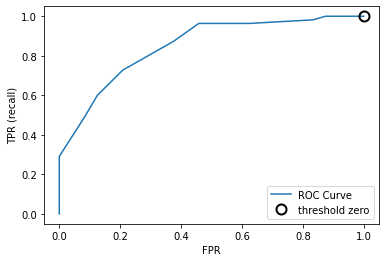

In [ ]:
# Show KNN ROC curve (Math, Grades)
fpr, tpr, thresholds = roc_curve(matytest, knn_mat.predict_proba(matXtest)[:, 1], pos_label="Pass")

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

print("KNN ROC (Math, Grades)")

KNN ROC (Portuguese, Grades)


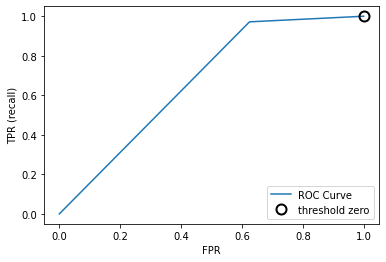

In [ ]:
# Show KNN ROC curve (Portuguese, Grades)
fpr, tpr, thresholds = roc_curve(porytest, knn_por.predict_proba(porXtest)[:, 1], pos_label="Pass")

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

print("KNN ROC (Portuguese, Grades)")

KNN PRC (Math, Social)


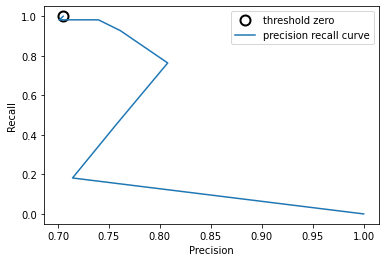

In [ ]:
# Calculate and Show KNN PRC results (Math, Social)
precision, recall, thresholds = precision_recall_curve(matytest2, knn_mat2.predict_proba(matXtest2)[:, 1], pos_label="Pass")
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

print("KNN PRC (Math, Social)")

KNN PRC (Portuguese, Social)


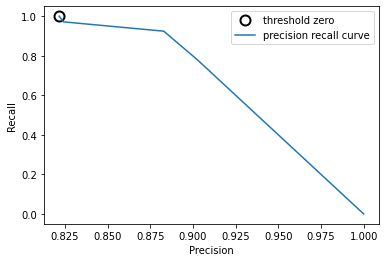

In [ ]:
# Calculate and Show KNN PRC results (Portuguese, Social)
precision, recall, thresholds = precision_recall_curve(porytest2, knn_por2.predict_proba(porXtest2)[:, 1], pos_label="Pass")
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

print("KNN PRC (Portuguese, Social)")

KNN ROC (Math, Social)


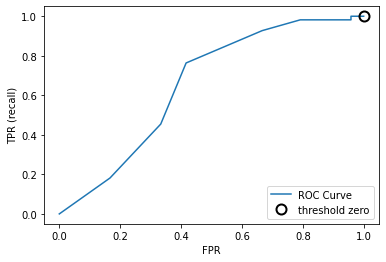

In [ ]:
# Show KNN ROC curve (Math, Social)
fpr, tpr, thresholds = roc_curve(matytest2, knn_mat2.predict_proba(matXtest2)[:, 1], pos_label="Pass")

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

print("KNN ROC (Math, Social)")

KNN ROC (Portuguese, Social)


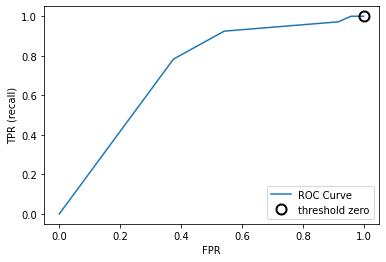

In [ ]:
# Show KNN ROC curve (Portuguese, Social)
fpr, tpr, thresholds = roc_curve(porytest2, knn_por2.predict_proba(porXtest2)[:, 1], pos_label="Pass")

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

print("KNN ROC (Portuguese, Social)")

In [ ]:
# KNN K-Fold Cross Validation
kf = KFold(n_splits=10,shuffle=True)

# KNN CV Scores - All Parameters
knn_mat_cvscore = cross_val_score(knn_mat,df_mat,y_mat,cv=kf)
knn_por_cvscore = cross_val_score(knn_por,df_por,y_por,cv=kf)

# KNN CV Scores - Social
knn_mat_cvscore2 = cross_val_score(knn_mat2,df_mat_social,y_mat,cv=kf)
knn_por_cvscore2 = cross_val_score(knn_mat2,df_por_social,y_por,cv=kf)

# Print
print("KNN Math CV Score (All): {:.2f}".format(knn_mat_cvscore.mean()))
print("KNN Port. CV Score (All): {:.2f}".format(knn_por_cvscore.mean()))
print("KNN Math CV Score (Social): {:.2f}".format(knn_mat_cvscore2.mean()))
print("KNN Port. CV Score (Social): {:.2f}".format(knn_por_cvscore2.mean()))

KNN Math CV Score (All): 0.81
KNN Port. CV Score (All): 0.86
KNN Math CV Score (Social): 0.70
KNN Port. CV Score (Social): 0.85


In [ ]:
# KNN Classification Reports

print("KNN Math Classification Report (All)\n",classification_report(matytest,knn_mat_pred))
print("KNN Port. Classification Report (All)\n",classification_report(porytest,knn_por_pred))
print("KNN Math Classification Report (Social)\n",classification_report(matytest,knn_mat_pred2))
print("KNN Port. Classification Report (Social)\n",classification_report(porytest,knn_por_pred2))

KNN Math Classification Report (All)
               precision    recall  f1-score   support

        Fail       0.87      0.54      0.67        24
        Pass       0.83      0.96      0.89        55

    accuracy                           0.84        79
   macro avg       0.85      0.75      0.78        79
weighted avg       0.84      0.84      0.82        79

KNN Port. Classification Report (All)
               precision    recall  f1-score   support

        Fail       0.75      0.38      0.50        24
        Pass       0.87      0.97      0.92       106

    accuracy                           0.86       130
   macro avg       0.81      0.67      0.71       130
weighted avg       0.85      0.86      0.84       130

KNN Math Classification Report (Social)
               precision    recall  f1-score   support

        Fail       0.67      0.33      0.44        24
        Pass       0.76      0.93      0.84        55

    accuracy                           0.75        79
   macro a

---


#Cross Validation


---

{'boxes': [<matplotlib.lines.Line2D at 0x7fe8b7ed0510>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe8b7ed5590>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe8b7ede5d0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe8b7ede090>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe8b7ed0ad0>,
  <matplotlib.lines.Line2D at 0x7fe8b7e02390>]}

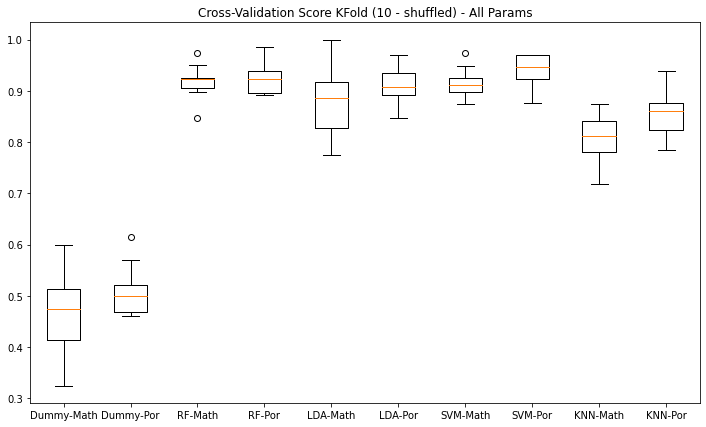

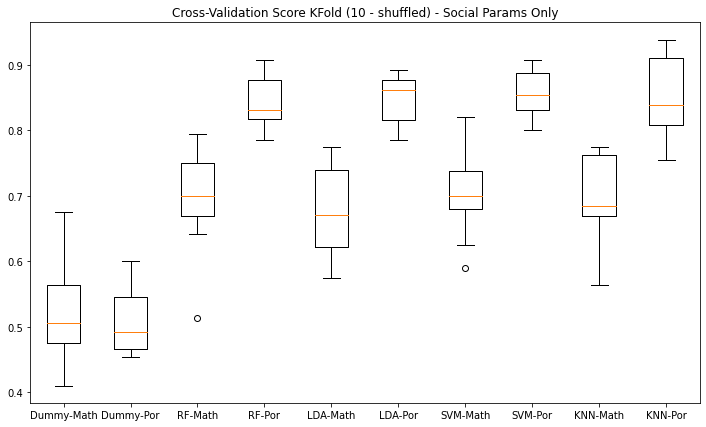

In [ ]:
# Dummy Cross Val Scores
  # mat_score_d, por_score_d
  # mat_score_d2, por_score_d2

# RF Cross Val Scores
  # rf_mat_score, rf_por_score
  # mat_score_rf_social, por_score_rf_social

# LDA Cross Val Scores
  # math_lda_cv_scores, por_lda_cv_scores
  # math_soc_lda_cv_scores, por_soc_lda_cv_scores

# SVM Cross Val Scores
  # SVCmat_score, SVCpor_score
  # SVCmat_score2, SVCpor_score2

# KNN Cross Val Scores
  # knn_mat_cvscore, knn_por_cvscore
  # knn_mat_cvscore2, knn_por_cvscore2

# Plot Cross Validation Compared to the dummy classifier
fig, box = plt.subplots(figsize=(12, 7))
data = [mat_score_d, por_score_d, rf_mat_score, rf_por_score, math_lda_cv_scores, 
        por_lda_cv_scores, SVCmat_score, SVCpor_score, knn_mat_cvscore, knn_por_cvscore]
box.set_title("Cross-Validation Score KFold (10 - shuffled) - All Params")
box.set_xticklabels(["Dummy-Math", "Dummy-Por", "RF-Math", "RF-Por", "LDA-Math", 
                     "LDA-Por", "SVM-Math", "SVM-Por", "KNN-Math", "KNN-Por"])
box.boxplot(data)

fig2, box2 = plt.subplots(figsize=(12, 7))
data2 = [mat_score_d2, por_score_d2, mat_score_rf_social, por_score_rf_social, 
         math_soc_lda_cv_scores, por_soc_lda_cv_scores, SVCmat_score2, SVCpor_score2, 
         knn_mat_cvscore2, knn_por_cvscore2]
box2.set_title("Cross-Validation Score KFold (10 - shuffled) - Social Params Only")
box2.set_xticklabels(["Dummy-Math", "Dummy-Por", "RF-Math", "RF-Por", "LDA-Math", 
                      "LDA-Por", "SVM-Math", "SVM-Por", "KNN-Math", "KNN-Por"])
box2.boxplot(data2)